Imports y configuración inicial

In [1]:
import os
import glob
from pathlib import Path
import json

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Directorios

In [2]:
DATA_DIR = '../dataset_landmarks'
OUT_DIR = '../dataset_landmarks_limpios'  # carpeta donde guardaremos resultados
Z_THRESH = 3.5  # umbral zscore 
TEST_SIZE = 0.15
VAL_SIZE = 0.15
SCALE_BY = 'wrist_to_mid' 

os.makedirs(OUT_DIR, exist_ok=True)
print('Directorio de datos:', DATA_DIR)
print('Salida:', OUT_DIR)

Directorio de datos: ../dataset_landmarks
Salida: ../dataset_landmarks_limpios


Funciones

In [3]:
def read_landmark_csv(path):
    """Lee un CSV y devuelve un DataFrame con solo las 63 columnas de landmarks (x0,y0,z0,...)
    Heurística:
      - Si existen columnas nombradas x0..x20, y0..y20, z0..z20 las usa en orden.
      - Si no, toma las últimas 63 columnas numéricas.
    """
    df = pd.read_csv(path)
    # Buscar columnas explícitas
    coords_expected = []
    for i in range(21):
        coords_expected += [f'x{i}', f'y{i}', f'z{i}']
    cols_lower = {c.lower(): c for c in df.columns}
    found = []
    for c in coords_expected:
        if c in cols_lower:
            found.append(cols_lower[c])
    if len(found) == 63:
        return df[found].astype(float)
    # fallback: últimas 63 columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) >= 63:
        return df[numeric_cols[-63:]].astype(float)
    raise ValueError(f"El archivo {path} no contiene 63 columnas numéricas esperadas. Tiene {len(numeric_cols)} numéricas.")


def drop_na_and_invalid(df):
    df = df.dropna()
    df = df[np.isfinite(df).all(axis=1)]
    return df


def remove_outliers_zscore(df, z_thresh=3.5):
    z = np.abs(stats.zscore(df, nan_policy='omit'))
    if np.isnan(z).any():
        z = np.nan_to_num(z)
    mask = (z < z_thresh).all(axis=1)
    return df[mask]


Prueba de lectura: listar archivos y leer primer CSV

In [4]:
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
if len(csv_paths) == 0:
    raise FileNotFoundError(f"No se encontraron CSVs en {DATA_DIR}. Revisa la ruta y que los archivos existan.")
print(f"Encontrados {len(csv_paths)} archivos. Algunos ejemplos:")
for p in csv_paths[:10]:
    print(' -', Path(p).name)


Encontrados 35 archivos. Algunos ejemplos:
 - 1.csv
 - 10.csv
 - 2.csv
 - 4.csv
 - 5.csv
 - 7.csv
 - 8.csv
 - A.csv
 - B.csv
 - C.csv


Lectura del primer csv

In [5]:
sample_path = csv_paths[0]
print('\nLeyendo ejemplo:', sample_path)
df_sample = read_landmark_csv(sample_path)
print('Shape (filas,cols):', df_sample.shape)
print('Primeras filas:')
df_sample.head()


Leyendo ejemplo: ../dataset_landmarks\1.csv
Shape (filas,cols): (1010, 63)
Primeras filas:


,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,0.976167,0.935086,1.263489e-07,0.909479,0.859301,-0.082394,0.891111,0.737041,-0.101947,0.926939,...,0.023322,1.046455,0.694623,-0.004250,1.023259,0.748847,-0.004691,1.018845,0.772448,0.007369
1,0.774872,0.945911,-4.734267e-07,0.708595,0.923146,-0.024590,0.636171,0.789891,-0.041221,0.656350,...,-0.054260,0.845544,0.681231,-0.083820,0.816231,0.771535,-0.051865,0.827097,0.786987,-0.021315
2,0.768530,0.923913,-4.701951e-07,0.701833,0.900555,-0.027517,0.628523,0.771301,-0.046034,0.649298,...,-0.059107,0.834439,0.657366,-0.091180,0.809081,0.747573,-0.062135,0.818523,0.763340,-0.033500
3,0.756638,0.938282,-3.484430e-07,0.683843,0.909858,-0.037562,0.613611,0.795676,-0.065178,0.619806,...,-0.079243,0.814981,0.690621,-0.111851,0.789524,0.772516,-0.088221,0.802627,0.775807,-0.062838
4,0.744503,0.968999,-4.107216e-07,0.670218,0.934080,-0.036598,0.601867,0.824711,-0.062095,0.600594,...,-0.075973,0.803223,0.720803,-0.106492,0.777488,0.798136,-0.085462,0.785964,0.800604,-0.062352


Aplicar limpieza por archivo y ver conteos

In [6]:
all_X = []
all_y = []
label_names = []

for p in csv_paths:
    label = Path(p).stem
    print(f"\nProcesando {label}...")
    df_lm = read_landmark_csv(p)
    n0 = len(df_lm)
    df_lm = drop_na_and_invalid(df_lm)
    n1 = len(df_lm)
    df_lm = remove_outliers_zscore(df_lm, z_thresh=Z_THRESH)
    n2 = len(df_lm)
    print(f"  filas: raw={n0}, tras_dropna={n1}, tras_zscore={n2}")
    if n2 == 0:
        print('  -> Atención: no quedaron filas tras limpieza para esta clase. Revisa datos o baja Z_THRESH.')
    for _, row in df_lm.iterrows():
        all_X.append(row.values.astype(float))
        all_y.append(label)
    label_names.append(label)

X = np.vstack(all_X) if len(all_X)>0 else np.empty((0,63))
y_labels = np.array(all_y)
print('\nTotal muestras tras limpieza:', X.shape[0])


Procesando 1...
  filas: raw=1010, tras_dropna=1010, tras_zscore=975

Procesando 10...
  filas: raw=2683, tras_dropna=2683, tras_zscore=2679

Procesando 2...
  filas: raw=1003, tras_dropna=1003, tras_zscore=983

Procesando 4...
  filas: raw=1009, tras_dropna=1009, tras_zscore=1002

Procesando 5...
  filas: raw=1009, tras_dropna=1009, tras_zscore=989

Procesando 7...
  filas: raw=1014, tras_dropna=1014, tras_zscore=998

Procesando 8...
  filas: raw=1482, tras_dropna=1482, tras_zscore=1423

Procesando A...
  filas: raw=2152, tras_dropna=2152, tras_zscore=2021

Procesando B...
  filas: raw=3230, tras_dropna=3230, tras_zscore=3086

Procesando C...
  filas: raw=2114, tras_dropna=2114, tras_zscore=2020

Procesando D...
  filas: raw=2129, tras_dropna=2129, tras_zscore=2017

Procesando E...
  filas: raw=2246, tras_dropna=2246, tras_zscore=2153

Procesando F...
  filas: raw=2136, tras_dropna=2136, tras_zscore=2038

Procesando G...
  filas: raw=92, tras_dropna=92, tras_zscore=86

Procesando H..

Mapear etiquetas a ids numéricos y revisar balance

In [7]:
unique_labels = sorted(list(set(y_labels)))
label2id = {name: idx for idx, name in enumerate(unique_labels)}
y = np.array([label2id[l] for l in y_labels], dtype=np.int32)
print('Clases encontradas:', len(unique_labels))
print('Ejemplo mapping (primeras 10):', dict(list(label2id.items())[:10]))

Clases encontradas: 35
Ejemplo mapping (primeras 10): {np.str_('1'): 0, np.str_('10'): 1, np.str_('2'): 2, np.str_('4'): 3, np.str_('5'): 4, np.str_('7'): 5, np.str_('8'): 6, np.str_('A'): 7, np.str_('B'): 8, np.str_('C'): 9}


In [8]:
# Conteo por clase

In [9]:
import collections
counts = collections.Counter(y)
print('\nConteo por clase (id: count) — muestra parcial:')
for k in sorted(counts)[:10]:
    print(k, counts[k])


Conteo por clase (id: count) — muestra parcial:
0 975
1 2679
2 983
3 1002
4 989
5 998
6 1423
7 2021
8 3086
9 2020


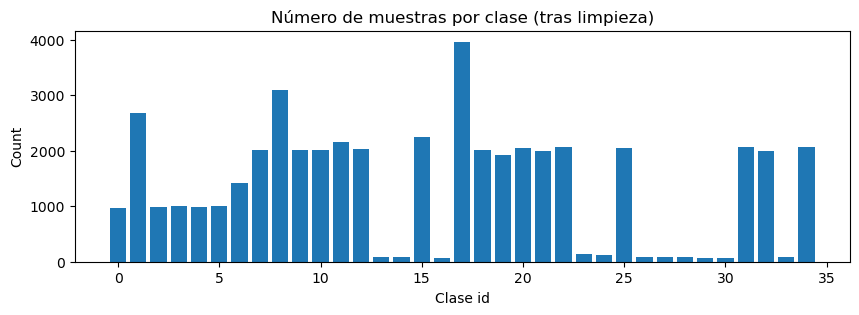

In [10]:
# Mostrar histograma de conteos por clase
plt.figure(figsize=(10,3))
plt.bar(range(len(unique_labels)), [counts.get(i,0) for i in range(len(unique_labels))])
plt.title('Número de muestras por clase (tras limpieza)')
plt.xlabel('Clase id')
plt.ylabel('Count')
plt.show()

Normalización: centrar en muñeca y escalar

In [11]:
def center_and_scale_vec(vec63, scale_by='wrist_to_mid'):
    pts = vec63.reshape(21,3).astype(float)
    wrist = pts[0].copy()
    centered = pts - wrist
    if scale_by == 'wrist_to_mid':
        ref = np.linalg.norm(centered[12])
    elif scale_by == 'max_dist':
        ref = np.max(np.linalg.norm(centered, axis=1))
    else:
        ref = 1.0
    if ref == 0 or np.isnan(ref):
        ref = 1.0
    scaled = centered / ref
    return scaled.reshape(63)

In [12]:
Aplicar normalización a todo el dataset

SyntaxError: invalid syntax (3243514196.py, line 1)

In [13]:
X_norm = np.array([center_and_scale_vec(x, scale_by=SCALE_BY) for x in X])
print('X_norm shape:', X_norm.shape)

X_norm shape: (47799, 63)


Visualizar 5 muestras (x,y)

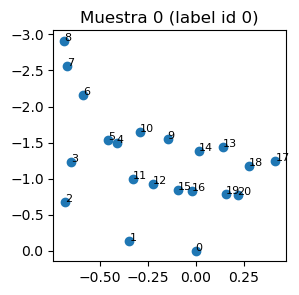

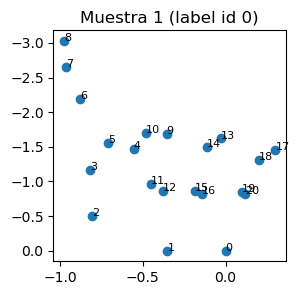

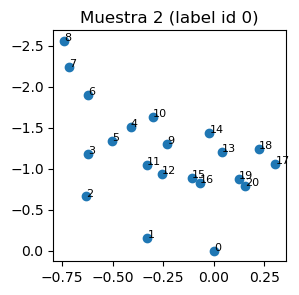

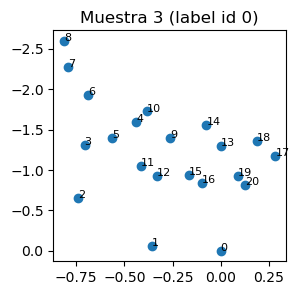

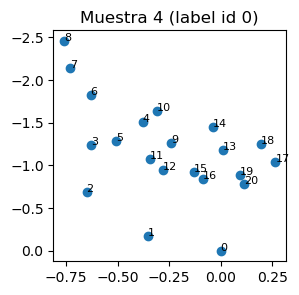

In [14]:
for i in range(min(5, X_norm.shape[0])):
    pts = X_norm[i].reshape(21,3)
    plt.figure(figsize=(3,3))
    plt.scatter(pts[:,0], pts[:,1])
    for j,p in enumerate(pts):
        plt.text(p[0], p[1], str(j), fontsize=8)
    plt.gca().invert_yaxis()
    plt.title(f'Muestra {i} (label id {y[i]})')
    plt.show()

 Split train/val/test (estratificado)

In [15]:

X_trainval, X_test, y_trainval, y_test = train_test_split(X_norm, y, test_size=TEST_SIZE, stratify=y, random_state=42)
val_prop = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_prop, stratify=y_trainval, random_state=42)

print('Shapes:')
print(' X_train', X_train.shape)
print(' X_val  ', X_val.shape)
print(' X_test ', X_test.shape)

Shapes:
 X_train (33459, 63)
 X_val   (7170, 63)
 X_test  (7170, 63)


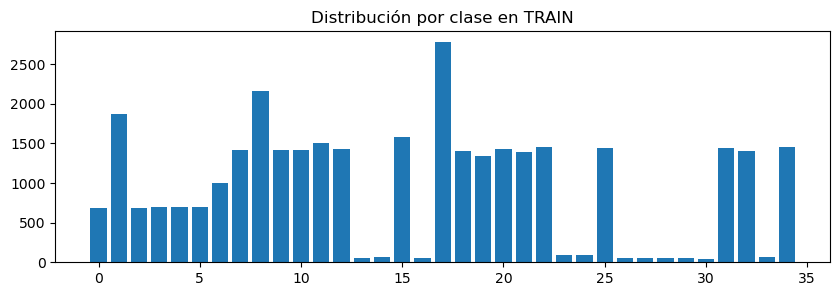

In [16]:
train_counts = np.bincount(y_train)
plt.figure(figsize=(10,3))
plt.bar(range(len(train_counts)), train_counts)
plt.title('Distribución por clase en TRAIN')
plt.show()

In [17]:
np.save(os.path.join(OUT_DIR, 'X_train.npy'), X_train)
np.save(os.path.join(OUT_DIR, 'y_train.npy'), y_train)
np.save(os.path.join(OUT_DIR, 'X_val.npy'), X_val)
np.save(os.path.join(OUT_DIR, 'y_val.npy'), y_val)
np.save(os.path.join(OUT_DIR, 'X_test.npy'), X_test)
np.save(os.path.join(OUT_DIR, 'y_test.npy'), y_test)
with open(os.path.join(OUT_DIR, 'label2id.json'), 'w') as f:
    json.dump(label2id, f, indent=2)
print('Guardado en', OUT_DIR)

Guardado en ../dataset_landmarks_limpios


In [18]:
import numpy as np, json
X_train = np.load("../dataset_landmarks_limpios/X_train.npy")
y_train = np.load("../dataset_landmarks_limpios/y_train.npy")
X_val   = np.load("../dataset_landmarks_limpios/X_val.npy")
y_val   = np.load("../dataset_landmarks_limpios/y_val.npy")
X_test  = np.load("../dataset_landmarks_limpios/X_test.npy")
y_test  = np.load("../dataset_landmarks_limpios/y_test.npy")
with open("../dataset_landmarks_limpios/label2id.json") as f:
    label2id = json.load(f)

print("Shapes:")
print(" X_train", X_train.shape)
print(" X_val  ", X_val.shape)
print(" X_test ", X_test.shape)
print("Clases:", len(label2id))

Shapes:
 X_train (33459, 63)
 X_val   (7170, 63)
 X_test  (7170, 63)
Clases: 35
